Project done by:
- Luca Domeniconi
- Tian Cheng Xia

# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

----
----

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image, ImageDraw
from sklearn.linear_model import LinearRegression
from enum import Enum
from typing import Optional
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.WARN)

### Configuration variables

In [3]:
DATASET_DIR = "./dataset"
TEMPLATES_DIR_NAME = "models"
SCENES_DIR_NAME = "scenes"
TEMPLATES_FILE_NAME = "ref{index}.png"
SCENE_FILE_NAME = "scene{index}.png"

SINGLE_INSTANCE_TEMPLATE_IDXS = [ *range(1, 15) ]
SINGLE_INSTANCE_SCENE_IDXS = [ *range(1, 6) ]
MULTIPLE_INSTANCES_TEMPLATE_IDXS = [ *range(15, 28) ]
MULTIPLE_INSTANCES_SCENE_IDXS = [ *range(6, 13) ]

FLANN_INDEX_KDTREE = 1

SHOW_PLOTS = True

### Loading images

In [4]:
def loadImage(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

template_dir = os.path.join(DATASET_DIR, TEMPLATES_DIR_NAME)
scene_dir = os.path.join(DATASET_DIR, SCENES_DIR_NAME)

single_instance_templates = [ loadImage( os.path.join(template_dir, TEMPLATES_FILE_NAME.format(index=i)) ) for i in SINGLE_INSTANCE_TEMPLATE_IDXS ]
single_instance_scenes = [ loadImage( os.path.join(scene_dir, SCENE_FILE_NAME.format(index=i)) ) for i in SINGLE_INSTANCE_SCENE_IDXS ]
multi_instance_templates = [ loadImage( os.path.join(template_dir, TEMPLATES_FILE_NAME.format(index=i)) ) for i in MULTIPLE_INSTANCES_TEMPLATE_IDXS ]
multi_instance_scenes = [ loadImage( os.path.join(scene_dir, SCENE_FILE_NAME.format(index=i)) ) for i in MULTIPLE_INSTANCES_SCENE_IDXS ]

### Evaluation function (for testing)

In [5]:
single_instance_ground_truth = {
    1: {1: 1, 2: 1},
    2: {3: 1, 4: 1, 5: 1},
    3: {6: 1, 7: 1, 8: 1},
    4: {1: 1, 7: 1, 8: 1, 9: 1, 10: 1},
    5: {11: 1, 12: 1}
}

multi_instance_ground_truth = {
    6: { 15: 2 },
    7: { 16: 2 },
    8: { 17: 2, 23: 2, 24: 1, 27: 1 },
    9: { 18: 2, 19: 2, 20: 2 },
    10: { 21: 2, 22: 2 },
    11: { 17: 2, 23: 2, 24: 2, 25: 3 },
    12: { 26: 2, 27: 2, 18: 2 }
}

def evaluate(prediction, ground_truth):
    corrects = { idx: 0 for idx in prediction.keys() }
    mistakes = { idx: 0 for idx in prediction.keys() }
    missing = { idx: 0 for idx in prediction.keys() }
    exceedings = { idx: 0 for idx in prediction.keys() }

    for scene_idx, preds in prediction.items():
        for template_idx, num_instances in ground_truth[scene_idx].items():
            if template_idx not in preds:
                missing[scene_idx] += num_instances
            elif preds[template_idx] < num_instances:
                missing[scene_idx] += num_instances - preds[template_idx]
                corrects[scene_idx] += preds[template_idx]
            elif preds[template_idx] > num_instances:
                exceedings[scene_idx] += preds[template_idx] - num_instances
                corrects[scene_idx] += num_instances
            else:
                corrects[scene_idx] += num_instances

        for template_idx, num_detections in preds.items():
            if template_idx not in ground_truth[scene_idx]:
                mistakes[scene_idx] += num_detections

    for scene_idx in prediction.keys():
        logger.info(
            f"Correctness scene{scene_idx}: {corrects[scene_idx]}/{sum([*ground_truth[scene_idx].values()])} "
            f"({mistakes[scene_idx]} mistakes, {missing[scene_idx]} missing, {exceedings[scene_idx]} exceedings)"
        )

### Utility functions

In [6]:
def clampVertexes(vertexes, image):
    """
        Fits the coordinates of a polygon within an image.
    """
    vertexes = vertexes.copy()
    for i in range(len(vertexes)):
        vertexes[i] = (max(0, min(vertexes[i][0], image.shape[1]-1)), max(0, min(vertexes[i][1], image.shape[0]-1)))
    return vertexes
    

def applyPolygonalMask(image, polygon_vertexes, inplace=False):
    """
        Sets, in the input image, an area defined by a polygon to 0.
    """
    if not inplace: image = image.copy()
    
    image_mask = Image.new("L", (image.shape[1], image.shape[0]), 0)
    ImageDraw.Draw(image_mask).polygon([
        (max(0, int(pt[0])), max(0, int(pt[1]))) for pt in polygon_vertexes
    ], outline=1, fill=1)
    mask = np.array(image_mask)
    image[ mask == 1, : ] = 0

    return image


def formatResultBox(object_vertexes):
    """
        Formats a polygonal bounding box into a rectangle.
        Assuming that the polygon is rectangle-like, the output box is obtained by
        averaging across all the axes.
    """
    top_left = object_vertexes[0]
    bottom_left = object_vertexes[1]
    bottom_right = object_vertexes[2]
    top_right = object_vertexes[3]

    left_x_mean = int( (top_left[0] + bottom_left[0]) / 2 )
    right_x_mean = int( (top_right[0] + bottom_right[0]) / 2 )
    top_y_mean = int( (top_left[1] + top_right[1]) / 2 )
    bottom_y_mean = int( (bottom_left[1] + bottom_right[1]) / 2 )

    return (left_x_mean, top_y_mean), right_x_mean-left_x_mean, bottom_y_mean-top_y_mean


def printResults(scene_idx, template_idx, bounding_boxes):
    """
        Prints the results following the required format.
    """
    print(f"Product {template_idx} - Scene {scene_idx} - {len(bounding_boxes)} instance found:")
    for i, polygon in enumerate(bounding_boxes):
        top_left, width, height = formatResultBox(polygon)
        print( f"Instance {i+1} {{position: {top_left}, width: {width}px, height: {height}px}}" )


def getRandomColor(idx):
    """
        Returns a color for matplotlib.
    """
    colors = "rgbcmk"
    return colors[ idx % len(colors) ]

## 1. Introduction


### Overall idea
Given a scene and a template image, the overall idea of the method we implemented is the following:
- `Candidates detection`: Determine possible candidate instances in the scene that match the template. As SIFT works on grayscale images, this step is "colorblind".
- `Color matching`: Given the candidates found at the previous step, check if the color of a match is coherent with the template.


### Notebook structure
The next sections of this notebook are structured in the following way:

2. We describe the strategies we adopted for image filtering.
3. We present the components we defined for `candidates detection`.
4. We present the components we defined for `color matching`.
5. We put everything together and describe the overall workflow.
6. We conclude by presenting the results.

## 2. Image filtering

Due to the noisiness of the images, we tested various combinations of filters following the rule-of-thumb of using a median filter to remove salt-and-pepper noise followed by a filter to remove Gaussian noise (bilateral filter in our case).

As we decoupled the tasks of `candidates detection` and `color matching`, we defined two different filters.

In [7]:
def filterKeypoints(image):
    image = cv2.medianBlur(image, 9)
    image = cv2.bilateralFilter(image, d=-1, sigmaColor=25, sigmaSpace=15)
    return image


def filterColor(image):
    image = cv2.medianBlur(image, 9)
    image = cv2.bilateralFilter(image, d=-1, sigmaColor=50, sigmaSpace=15)
    return image

## 3. Candidates detection

In this section, we present the components needed for the `candidates detection` phase. In summary, the following criteria are used:
- A score based on the density of the keypoints.
- The area of the polygon defined by the vertexes of the matched instance.
- The amount of overflow from the image boundaries of the vertexes of the matched instance.

### Coverage density computation

To address the issue of instances that partially match the template (e.g., two different boxes of cereals of the same brand), we implemented a strategy that partitions the template image based on the density of its SIFT keypoints. Then, we defined a score, which we denote as **density**, based on the number of sections covered by at least a matching keypoint.

The idea behind this method is that, as keypoints are located at interesting points of the image, it is able to detect which areas of the template are important. Therefore, images with partial similarities will result in different splits and will be easier to disambiguate as a partially matched template yields a lower density score, even if the total number of matches is high.

Given a rectangle (i.e., an image), if a certain number of keypoints are within it, it is split into four new sub-rectangles of equal size and the process is recursively repeated on the new sub-rectangles for a given number of times.
Moreover, if a sub-rectangle ends up not having any points within it, it is discarded as it can be considered to be not important for the overall detection of that specific template.

This process will result in regions with different sizes and roughly containing an equal number of keypoints.

Obviously, it would be more correct to split in sub-rectangles of different size depending on the concentration of points. Nevertheless, equal splits have a good trade-off between simplicity and accuracy.

In [8]:
def split_rect(rect, points, k=5, max_depth=4):
    """
        Splits the given rectangle into four sub-rectangles if there are at least k points inside it.
        A split is done by dividing the rectangle into four equal areas.

        Parameters
        ----------
            rect : tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]
                Vertexes of the rectangle.
                (upper_right, upper_left, lower_left, lower_right)

            points : list[tuple[int, int]]
                Points used to determine the density.

            k : int
                Minimum number of points required to allow a further split.

            max_depth : int
                Maximum number of splits (i.e., number of recursive call).

        Returns
        -------
            rects : list[tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]]
                Partition of the input rectangle.
    """
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    # Determine the points within this rectangle
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]

    # If the rectangle does not contains points, it is excluded from the final result
    if len(inside_points) == 0:
        return None
    
    if max_depth == 0:
        return []
    
    # A further split can be performed
    if len(inside_points) > k:
        # Split the current rectangle
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        # Try to further split the new sub-rectangles
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth-1)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth-1)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth-1)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth-1)

        for s, r in [(upper_right_split, upper_right_rect), (upper_left_split, upper_left_rect), (lower_left_split, lower_left_rect), (lower_right_split, lower_right_rect)]:
            if s is not None:
                if len(s) > 0:
                    # The split produced new sub-sub-rectangles, use these in the output
                    rects += s
                else:
                    # The split did not produce new sub-sub-rectangles, use the original sub-rectangle in the output.
                    rects += [r]
            
    return rects

Partitioning should only be done using significant keypoints as its aim is to determine which areas of the image are more relevant.
For this reason, partitioning is done by using a set of SIFT parameters that produce a low number of keypoints. 
For more robustness, these parameters are modified if splitting is not possible.

In [9]:
def generateTemplateDensitySplits(template, contrast_th_start=0.16, contrast_th_step=-0.02, edge_th_start=8.0, edge_th_step=0.5, split_k=3, split_depth=3):
    """
        Partitions an image based on the density of its keypoints.
    """
    contrastThreshold = contrast_th_start
    edgeThreshold = edge_th_start
    splitted_template = None

    # Try different SIFT parameters until a partitioning is found.
    while (splitted_template is None) or (len(splitted_template) == 0):
        sift_template_split = cv2.SIFT_create(
            contrastThreshold = contrastThreshold,
            edgeThreshold = edgeThreshold
        )
        h_template, w_template, _ = template.shape

        kp_template_rect = sift_template_split.detect(template)
        kp_template_rect, _ = sift_template_split.compute(template, kp_template_rect)
        splitted_template = split_rect(
            rect = ((w_template, h_template), (0, h_template), (0, 0), (w_template, 0)),
            points = [ (kp.pt[0], kp.pt[1]) for kp in kp_template_rect ],
            k = split_k,
            max_depth = split_depth
        )

        # Update SIFT parameters
        contrastThreshold += contrast_th_step
        edgeThreshold += edge_th_step

    return splitted_template

The density score based on this splitting algorithm is computed as:

$$ \texttt{density} = \frac{\text{number of splits with at least a matching keypoint within it}}{\text{total number of splits}} $$

In [10]:
def getDensity(matched_kp: list[tuple[float, float]], template_partition: list):
    """
        Returns the percentage of the template partitions that have been matched by at least one keypoint.
    """
    match_count = { s: 0 for s in template_partition }
    
    # Counts the number of matched keypoints that ended up in a section
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1
                break

    return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

# TODO Example <-----------------------------------------

### Other match validation criteria

These simple criteria are used to quickly detect matches that are surely wrong.

In [11]:
def polygonArea(points):
    """
        Computes the area of the polygon defined by its vertexes.
    """
    x = np.array([ pt[0] for pt in points ])
    y = np.array([ pt[1] for pt in points ])
    return 0.5 * np.abs( (x @ np.roll(y,1)) - (y @ np.roll(x,1)) )


def areVertexesOverflowing(vertexes, image, tolerance_ratio):
    """
        Checks if a list of points overflows too much from a given image.
        The tolerance is proportional to the size of the image.
    """
    tolerance_x = image.shape[1] * tolerance_ratio
    tolerance_y = image.shape[0] * tolerance_ratio

    for point in vertexes:
        if ((point[0] > image.shape[1]+tolerance_x) or (point[0] < -tolerance_x) or 
            (point[1] > image.shape[0]+tolerance_y) or (point[1] < -tolerance_y)): 
            return True
    return False

## 4. Color matching

The `color matching` phase is done following two criteria:
- **Color difference**: An absolute comparison of the pixel intensities.
- **Affine transformation detection**: A linear model to detect whether there is an illumination change.

In this section, we first describe how the color intensity of a pixel is determined, then, we present the two criteria cited above and conclude with the overall method to compute the scores.

### Pixel color intensity computation

For more robustness against noise, we determine the color intensity of a pixel by averaging the intensities of a patch centered on it.

In [12]:
def getColorFeatureAt(image, x, y, window_size):
    """
        Computes the mean color of a patch centered on (x, y)
    """
    x, y = int(x), int(y)
    step = window_size // 2
    return np.mean(image[y-step : y+step+1, x-step : x+step+1], axis=(0, 1))


def getColorFeatures(image, to_check_points, window_size):
    """
        Computes the color features of a list of points.
    """
    h, w, _ = image.shape
    color_features = []
    min_x = np.min([ p[0] for p in to_check_points ])
    max_x = np.min([ p[0] for p in to_check_points ])
    min_y = np.min([ p[1] for p in to_check_points ])
    max_y = np.min([ p[1] for p in to_check_points ])

    # Pad image if needed
    if (min_x < window_size//2) or (min_y < window_size//2) or (max_x >= w-window_size//2) or (max_y >= h-window_size//2):
        padding = window_size // 2
        image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_REFLECT)
    else:
        padding = 0

    # Compute color features
    for x, y in to_check_points:
        color = getColorFeatureAt(image, x+padding, y+padding, window_size=window_size)
        color_features.append(color)

    return np.array(color_features)

### Color difference

This score is a direct color comparison and is determined as the mean pixel intensities difference in norm infinity (i.e., maximum in absolute value).

Pixels with a negligible difference are ignored in the mean computation. This allows to obtain more robustness when comparing images with mostly overlapping intensities but in a small portion.

In [13]:
def getColorAbsoluteConfidence(color_features_template, color_features_scene):
    """
        Compute the color difference score.
    """
    X = np.array(color_features_template)
    y = np.array(color_features_scene)
    diff = np.linalg.norm( X - y, np.inf, axis=1 )
    
    return np.mean(diff[diff > 25])

### Affine transformation detection

This score determines if there is an affine transformation (i.e., an illumination change) between the colors of the template and the scene.

To achieve this, we try to fit a linear model that maps the colors of the template to the scene (vice versa would work too). Between fitting a hyperplane across three channels and an individual line per channel, we observed that the latter works better. 
After the model is found, the coefficient of determination is used to measure its goodness and the minimum $R^2$ across the three channels is used as output score.

As above, pixels with a negligible intensity difference are ignored. In this case, we are mostly interested in finding a transformation for pixels with a large difference so the cutoff zone is slightly higher than above.

In [14]:
def getColorAffineConfidence(color_features_template, color_features_scene):
    """
        Compute the affine transformation confidence.
    """
    X = np.array(color_features_template)
    y = np.array(color_features_scene)
    diff = np.linalg.norm( X - y, np.inf, axis=1 )
    scores = []

    X = X[diff > 30]
    y = y[diff > 30]

    # Fit a different line per channel
    for i in range(X.shape[1]):
        X_c = X[:, i].reshape(-1, 1)
        y_c = y[:, i]
        reg = LinearRegression().fit(X_c, y_c)
        scores.append(reg.score(X_c, y_c))

    return np.min(scores)

### Color scores computation

In the complete workflow, color scores are computed at a point in the computation when it is possible to warp the scene into the template. This allows an easier comparison as we obtain two images of the same size.
Moreover, for both robustness and efficiency, color features are not computed across the entire image but at matched keypoints.
The main steps for color scores computation are the following:
- Warp scene points into template points.
- Mask, in the template image, points where warping was not possible.
- Compute and match SIFT keypoints between the masked template and warped scene. At this step, keypoints are recomputed as they are computed only considering a relevant portion of the scene, allowing to obtain more relevant points for a higher precision.
- Determine good keypoints matches. Differently from the normal case where KNN is used, at this stage we know that two images are similar, therefore, a good match is determined if the point in the template is not spatially too distant from its match in the scene.
- Compute color features and scores.

In [15]:
def getColorMatchConfidence(template_features, scene_for_color, scene_for_kp, homography_color, window_size) -> tuple[float, float]:
    """
        Computes the color scores between template and scene.

        Parameters
        ----------
            template
                Template to use to compute the scores.

            scene_for_color
                Scene to use to compute the scores.

            scene_for_kp
                Scene to use to compute the keypoints.

            homography_color
                Homography that maps scene points into template points.

            window_size
                Size of the patch for color features computation.

        Returns
        -------
            confidence_absolute: float
                Color difference score.

            confidence_affine: float
                Affine transformation score.
    """
    template = template_features.image
    h_template, w_template, _ = template.shape

    warped_scene = cv2.warpPerspective(scene_for_color, homography_color, (w_template, h_template))
    warped_scene_for_kp = cv2.warpPerspective(scene_for_kp, homography_color, (w_template, h_template))
    masked_template = np.where(warped_scene != 0, template, 0)

    sift = cv2.SIFT_create(contrastThreshold=0.001, nfeatures=6000)
    flann = cv2.FlannBasedMatcher(indexParams={ "algorithm": FLANN_INDEX_KDTREE, "trees": 2 }, searchParams={ "checks": 250 })

    # Filter out template keypoints at masked pixels
    kp_template = []
    desc_template = []
    for kp, desc in zip(template_features.kp_color, template_features.desc_color):
        if np.all(masked_template[int(kp.pt[1]), int(kp.pt[0])] != 0):
            kp_template.append(kp)
            desc_template.append(desc)
    desc_template = np.array(desc_template)
    
    kp_scene = sift.detect(warped_scene_for_kp)
    kp_scene, desc_scene = sift.compute(warped_scene_for_kp, kp_scene)
    matches = flann.knnMatch(desc_template, desc_scene, k=2)

    # Keypoints matching based on spatial distance
    to_check_points_template = []
    to_check_points_scene = []
    for m, _ in matches:
        if (np.sqrt((kp_template[m.queryIdx].pt[0] - kp_scene[m.trainIdx].pt[0])**2 + (kp_template[m.queryIdx].pt[1] - kp_scene[m.trainIdx].pt[1])**2) <= 20):
            to_check_points_template.append( kp_template[m.queryIdx].pt )
            to_check_points_scene.append( kp_scene[m.trainIdx].pt )


    color_features_scene = getColorFeatures(warped_scene, to_check_points_scene, window_size)
    color_features_template = getColorFeatures(masked_template, to_check_points_template, window_size)

    confidence_affine = getColorAffineConfidence(color_features_template, color_features_scene)
    confidence_absolute = getColorAbsoluteConfidence(color_features_template, color_features_scene)

    return confidence_absolute, confidence_affine

## 5. Complete workflow

### Template features pre-computation

To speed-up the workflow, the density partitioning of the templates can be pre-computed in advance as it is only dependent of the template image.
A different window size to use for color computation could also be used for each template image (which might be pre-determined based on the size and properties of the image). In the actual implementation, we use the same window size for all instances.

In [16]:
class TemplateFeatures:
    def __init__(
        self, template, 
        color_window_size=25,
        sift_candidates_params = { "contrastThreshold": 0.03, "nfeatures": 1000 },
        sift_color_params = { "contrastThreshold": 0.001, "nfeatures": 3000 }
    ):
        self.image = template
        self.splits = generateTemplateDensitySplits(template)
        self.color_window_size = color_window_size
        
        sift_candidates = cv2.SIFT_create(**sift_candidates_params)
        kp_template = sift_candidates.detect(template)
        kp_template, desc_template = sift_candidates.compute(template, kp_template)
        self.kp_candidates = kp_template
        self.desc_candidates = desc_template

        sift_color = cv2.SIFT_create(**sift_color_params)
        kp_template = sift_color.detect(template)
        kp_template, desc_template = sift_color.compute(template, kp_template)
        self.kp_color = kp_template
        self.desc_color = desc_template


    def matchDensity(self, matched_template_kp):
        return getDensity(matched_template_kp, self.splits)


    def matchColor(self, scene, scene_for_kp, homography_color):
        return getColorMatchConfidence(self, scene, scene_for_kp, homography_color, self.color_window_size)

### Candidates detection

During `candidates detection`, a match is discarded if:
- The area defined by the boundaries of the detection is below a given threshold.
- There is at least a vertex that overflows too much by a given tolerance.
- The density score is below a threshold. Note that if the image is only partially visible, the density score is rescaled based on the visible area.

In [17]:
class MismatchReason(Enum):
    OVERFLOW = 1
    AREA = 2
    DENSITY_VERY_LOW = 3
    DENSITY = 4
    COLOR_VERY_LOW = 5
    COLOR = 6


class CandidateInstance:
    def __init__(self, vertexes, diff_score, affine_score):
        self.vertexes = vertexes
        self.diff_score = diff_score
        self.affine_score = affine_score


def matchKeypoints(
        scene, 
        template, 
        sift_scene_params = { "contrastThreshold": 0.015 }, 
        sift_template_params = { "contrastThreshold": 0.03, "nfeatures": 500 }, 
        flann_params = {
            "indexParams": { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
            "searchParams": { "checks": 500 }
        }
    ):
    """
        Finds and matches keypoints.
    """
    sift = cv2.SIFT_create(**sift_scene_params)
    sift_template = cv2.SIFT_create(**sift_template_params)
    flann = cv2.FlannBasedMatcher(**flann_params)

    # Use pre-computed keypoints and descriptors if available
    if isinstance(template, TemplateFeatures):
        kp_template = template.kp_candidates
        desc_template = template.desc_candidates
    else:
        kp_template = sift_template.detect(template)
        kp_template, desc_template = sift_template.compute(template, kp_template)
    kp_scene = sift.detect(scene)
    kp_scene, desc_scene = sift.compute(scene, kp_scene)
    
    matches = flann.knnMatch(desc_template, desc_scene, k=2)
    return kp_template, kp_scene, matches

In [18]:
def checkMismatch(
        object_vertexes: list[tuple[int, int]], 
        scene: np.ndarray, 
        template_features: TemplateFeatures, 
        overflow_tol_ratio: float,
        min_area_ratio: float, 
        density_threshold: float, 
        matched_template_points: list[tuple[int, int]]
    ) -> Optional[MismatchReason]:
    """
        Determine if a detection is valid.

        Parameters
        ----------
            object_vertexes: list[tuple[float, float]]
                Vertexes of the polygon containing the detected instance.

            scene: np.ndarray

            template_features: TemplateFeatures

            overflow_tol_ratio: float
                Ratio to determine the amount of allowed overflow.
            
            min_area_ratio: float
                Minimum area of the detected polygon.

            density_threshold: float
                Minimum ratio of density splits that should be matched.
            
            matched_template_points: list[tuple[int, int]]
                Points in the template that have been matched to the scene.

        Returns
        -------
            mismatch_reason : Optional[MismatchReason]
    """
    scene_area = scene.shape[0] * scene.shape[1]

    # The area of the polygon is too small.
    detected_full_area = polygonArea(object_vertexes)
    if detected_full_area < scene_area*min_area_ratio:
        logger.info(f"Invalid for area {detected_full_area:.4f} < {scene_area*min_area_ratio:.4f}")
        return MismatchReason.AREA

    # The vertexes of the polygon overflow too much from the borders of the image.
    if areVertexesOverflowing(object_vertexes, scene, overflow_tol_ratio): 
        logger.info(f"Invalid for overflow")
        return MismatchReason.OVERFLOW
    
    # The density of the points is too low.
    detected_positive_area = max( 1, polygonArea(clampVertexes(object_vertexes, scene)) )
    density_multiplier = detected_full_area / detected_positive_area # Multiplier to scale the density based on the visible area
    match_density = template_features.matchDensity(matched_template_points)
    if (match_density * density_multiplier) < density_threshold:
        logger.info(f"Invalid for density {match_density:.4f}*{density_multiplier:.4f} = {match_density*density_multiplier:.4f}")
        if (match_density * density_multiplier) < density_threshold*0.5:
            return MismatchReason.DENSITY_VERY_LOW 
        else: 
            return MismatchReason.DENSITY

    logger.info(f"Matched density: {match_density:.4f} * {density_multiplier:.4f} = {match_density*density_multiplier:.4f}")
    return None

The overall `candidates detection` method works as follows:
- SIFT keypoints are computed and matched in the traditional way using KNN.
- The homography from template to scene is found and the boundary vertexes of the matched candidate are determined.
- The match is tested using the function defined above.
    - If the match is confirmed, its color scores are computed (they are required in the next step, but it comes handy to compute them now), the matched portion of the scene image is masked, and keypoints are recomputed on the new scene.
    - If the match is not confirmed, the good matches threshold is increased. If the reason that failed matching is a very low density (i.e., below 50% of the threshold), the matched portion is masked in the scene image and keypoints are recomputed. This can be done as a low density indicates an object that only partially matches the template and is therefore safe to assume that we are not removing true instances or part of them.

Note that the good matches thresholds to try are an argument and the algorithm terminates when it tried all the thresholds.

In [19]:
def findCandidateInstances(
        scene_for_keypoints: np.ndarray, 
        scene_for_color: np.ndarray, 
        template_features: TemplateFeatures,
        to_try_thresholds: list[float] = np.arange(0.7, 0.8, 0.05),
        overflow_tol_ratio: float = 0.2, 
        min_area_ratio: float = 0.05,
        density_threshold: float = 0.40,
        seed: int = 42
    ):
    """
        Parameters
        ----------
            scene_for_keypoints : np.ndarray
                Scene in which the object should be found. This image is used to determine the keypoints.

            scene_for_color : np.ndarray
                Scene image used to determine the color scores.

            template_features : TemplateFeatures
                Template information.
            
            to_try_thresholds : list[float]
                Thresholds to try when filtering good matches.

            overflow_tol_ratio : float
                See above.
            
            min_area_ratio : float
                See above.
            
            density_threshold : float
                See above.
            
            seed : int
                Random seed for non-deterministic functions.
        
        Returns
        -------
            object_vertexes : list[ list[tuple[float, float]] ]
                List of vertexes of the boundaries of the matched objects in the scene.
    """
    cv2.setRNGSeed(seed)
    np.random.seed(seed)

    template = template_features.image
    h_template, w_template, _ = template.shape
    curr_threshold_idx = 0
    should_compute_keypoints = True
    candidates = []
    
    while True:
        # Recompute keypoints if needed
        if should_compute_keypoints:
            should_compute_keypoints = False
            kp_template, kp_scene, matches = matchKeypoints(scene_for_keypoints, template_features)

        good_matches = [ m for m, n in matches if m.distance < to_try_thresholds[curr_threshold_idx]*n.distance ]
        template_points = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
        scene_points = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)
        
        # Find the homography from template to scene
        try:
            homography, mask = cv2.findHomography(template_points, scene_points, cv2.RANSAC, ransacReprojThreshold=20.0)
            mask = mask[:, 0] == 1
            if homography is None: raise Exception("Homography not found")
        except:
            # Increase keypoints matching threshold
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
            continue
            
        # Compute the vertexes of the matched object in the scene
        object_vertexes = cv2.perspectiveTransform(
            src = np.float32([ [0,0], [0,h_template-1], [w_template-1,h_template-1], [w_template-1,0] ]).reshape(-1, 1, 2), 
            m = homography
        )
        object_vertexes = [pt[0] for pt in object_vertexes]

        invalidity_reason = checkMismatch(
            object_vertexes, 
            scene_for_keypoints, 
            template_features, 
            overflow_tol_ratio, 
            min_area_ratio, 
            density_threshold, 
            template_points[mask, :], 
        )

        if invalidity_reason is not None:
            # Increase keypoints matching threshold
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break

            if invalidity_reason in [ MismatchReason.DENSITY_VERY_LOW ]:
                # Mask the mismatched instance
                scene_for_keypoints = applyPolygonalMask(scene_for_keypoints, object_vertexes, inplace=True)
                should_compute_keypoints = True
        else: # Match found
            diff_score, affine_score = template_features.matchColor(scene_for_color, scene_for_keypoints, np.linalg.inv(homography))
            candidates.append(
                CandidateInstance(
                    vertexes = object_vertexes,
                    diff_score = diff_score,
                    affine_score = affine_score
                )
            )

            # Mask the matched instance
            scene_for_keypoints = applyPolygonalMask(scene_for_keypoints, object_vertexes, inplace=True)
            should_compute_keypoints = True
        
    return candidates

### Color matching

The overall `color matching` method slightly changes depending on the type of task. In both cases a hard and soft thresholds are used for the color difference score and a single threshold is used for the affine transformation score.

For single instance detection, the method works as follows:
- Consider the candidate with the lowest color difference score.
- If the color difference is below the hard threshold, consider it as a match and terminate.
- If the color difference is between the hard and soft thresholds, consider it as a match only if the affine transformation score is above its threshold.
- In all other cases, there is no match.

For multiple instance detection, two further thresholds are introduced (soft and hard neighborhood). The method works as follows:
- Consider the candidate $C_\text{min}$ with the lowest color difference score.
- If the color score or affine transformation score of $C_\text{min}$ do not respect the thresholds as defined for the single instance case, consider all instances as invalid matches.
- Otherwise, define a hard and soft neighborhood threshold based on the color score of $C_\text{min}$. These thresholds are defined as the color score plus some margin.
- Iterate over the candidates $C_i$ :
    - If the color score of $C_i$ is below the hard neighborhood threshold, consider it as a match.
    - If the color score of $C_i$ is between the hard and soft neighborhood threshold, consider it as a match only if the affine transformation score is above its threshold.
    - Otherwise, $C_i$ is not a match.

In [20]:
def colorComparisonSingleInstance(
        candidates, 
        diff_hard_thr = 40, 
        diff_soft_thr = 50, 
        affine_thr = 0.75
    ):
    min_diff_idx = np.argmin([ c.diff_score for c in candidates ])
    min_diff_score = candidates[min_diff_idx].diff_score
    min_affine_score = candidates[min_diff_idx].affine_score

    if min_diff_score < diff_hard_thr:
        logger.info(f"Matched absolute color: {min_diff_score:.4f}")
        return candidates[min_diff_idx]
    elif (diff_hard_thr <= min_diff_score < diff_soft_thr) and (min_affine_score >= affine_thr):
        logger.info(f"Matched absolute color: {min_diff_score:.4f} | Affine {min_affine_score:.4f}")
        return candidates[min_diff_idx]
    else:
        logger.info(f"Invalid for color {min_diff_score:.4f} | {min_affine_score:.4f}")
        return None
    

def colorComparisonMultiInstance(
        candidates, 
        diff_hard_thr = 40, 
        diff_soft_thr = 50, 
        affine_thr = 0.75, 
        neighbor_hard_thr_margin = 5, 
        neighbor_soft_thr_margin = 10
    ):
    min_diff_idx = np.argmin([ c.diff_score for c in candidates ])
    min_diff_score = candidates[min_diff_idx].diff_score
    min_affine_score = candidates[min_diff_idx].affine_score
    detections = []

    if (diff_hard_thr <= min_diff_score < diff_soft_thr and min_affine_score < affine_thr) or (min_diff_score >= diff_soft_thr): 
        return []
    neighbor_hard_thr = min_diff_score + neighbor_hard_thr_margin
    neighbor_soft_thr = min_diff_score + neighbor_soft_thr_margin

    for candidate in candidates:
        if candidate.diff_score <= neighbor_hard_thr:
            logger.info(f"Matched color absolute score: {candidate.diff_score:.4f} | Affine: {candidate.affine_score:.4f}")
            detections.append(candidate)
        elif candidate.diff_score <= neighbor_soft_thr and candidate.affine_score >= affine_thr:
            logger.info(f"Matched color absolute score: {candidate.diff_score:.4f} | Affine: {candidate.affine_score:.4f}")
            detections.append(candidate)
        else:
            logger.info(f"Invalid for color {[ f'{c.diff_score:.2f}' for c in candidates ]} | {[ f'{c.affine_score:.2f}' for c in candidates ]}")
    
    return detections

## 6. Results

### Single instance detection

In [21]:
def singleInstanceDetection(scene_kp, scene_color, template_features):
    candidates = findCandidateInstances(scene_kp.copy(), scene_color, template_features)
    if len(candidates) == 0: return None
    logger.info(f"Num candidates: {len(candidates)}")
    color_match = colorComparisonSingleInstance(candidates)
    
    return None if color_match is None else color_match.vertexes

In [22]:
single_templates_features = []
for template in single_instance_templates:
    single_templates_features.append(TemplateFeatures(template))

Product 1 - Scene 1 - 1 instance found:
Instance 1 {position: (10, 14), width: 803px, height: 1048px}
Product 2 - Scene 1 - 1 instance found:
Instance 1 {position: (846, 8), width: 802px, height: 1049px}
Product 3 - Scene 2 - 1 instance found:
Instance 1 {position: (3, 22), width: 604px, height: 941px}
Product 4 - Scene 2 - 1 instance found:
Instance 1 {position: (610, 6), width: 633px, height: 950px}
Product 5 - Scene 2 - 1 instance found:
Instance 1 {position: (1247, 28), width: 561px, height: 843px}
Product 6 - Scene 3 - 1 instance found:
Instance 1 {position: (-1, 122), width: 600px, height: 671px}
Product 7 - Scene 3 - 1 instance found:
Instance 1 {position: (619, 135), width: 541px, height: 650px}
Product 8 - Scene 3 - 1 instance found:
Instance 1 {position: (1168, 8), width: 558px, height: 780px}
Product 1 - Scene 4 - 1 instance found:
Instance 1 {position: (698, 660), width: 375px, height: 507px}
Product 7 - Scene 4 - 1 instance found:
Instance 1 {position: (-178, 87), width: 3

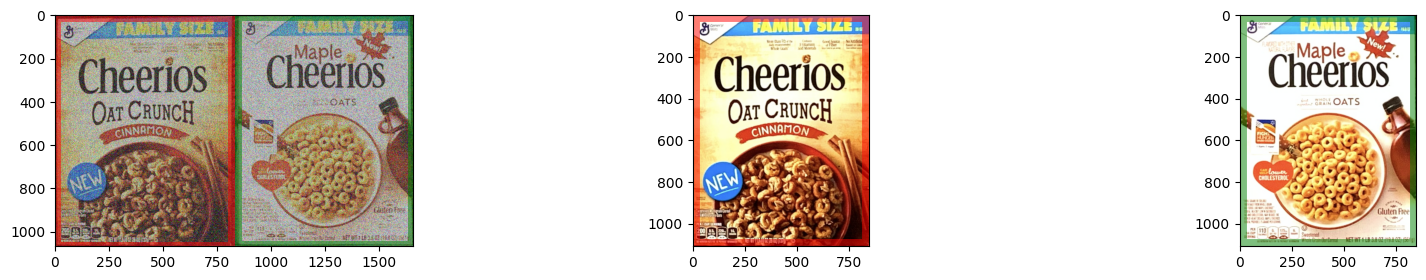

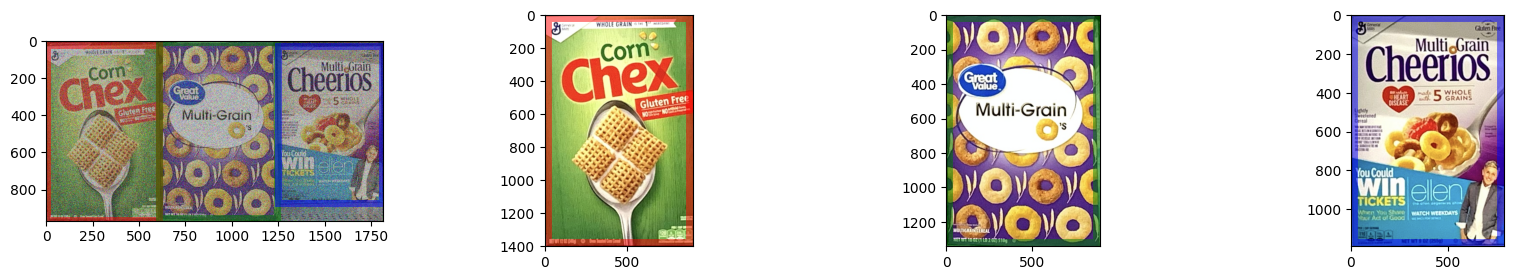

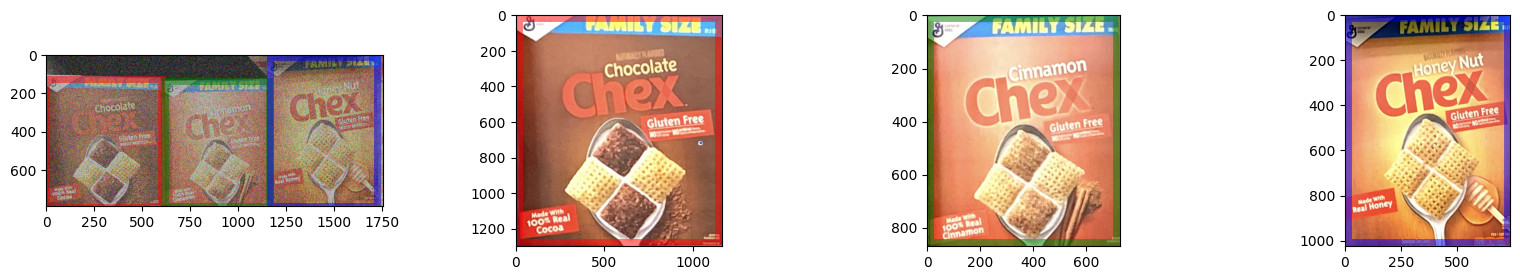

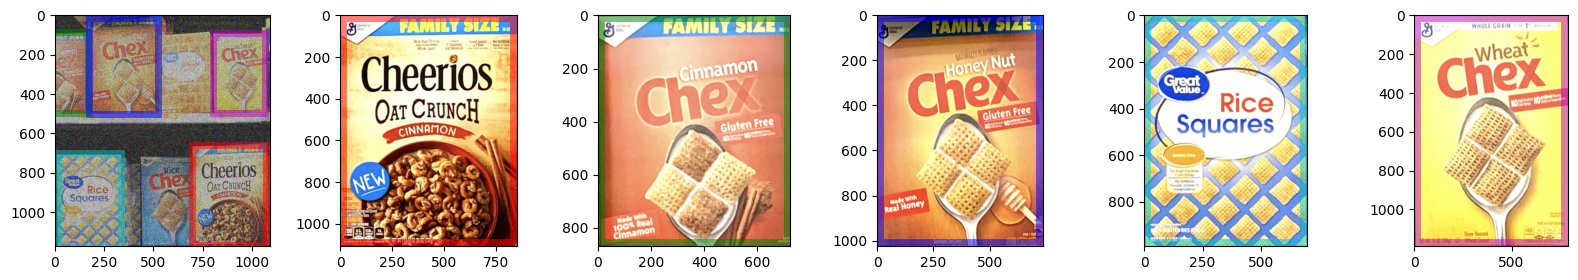

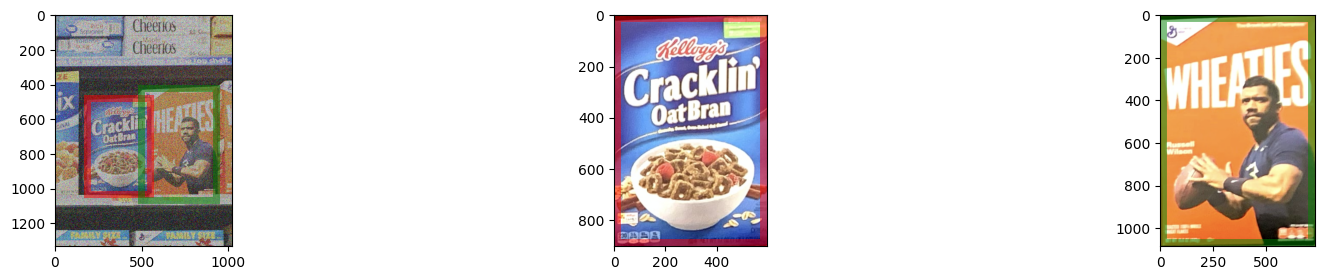

In [23]:
predictions_single = { idx: {} for idx in SINGLE_INSTANCE_SCENE_IDXS }
plot_data_single = { idx: {} for idx in SINGLE_INSTANCE_SCENE_IDXS }

for scene_idx, scene in zip(SINGLE_INSTANCE_SCENE_IDXS, single_instance_scenes):
    scene_keypoints = filterKeypoints(scene)
    scene_color = filterColor(scene)

    for template_idx, template_features in zip(SINGLE_INSTANCE_TEMPLATE_IDXS, single_templates_features):
        # if template_idx not in single_instance_ground_truth[scene_idx].keys(): continue
        object_vertexes = singleInstanceDetection(scene_keypoints, scene_color, template_features)
        
        if object_vertexes is None: 
            logger.info(f"Product {template_idx} - Scene {scene_idx} - No match found")
            continue

        printResults(scene_idx, template_idx, [object_vertexes])
        predictions_single[scene_idx][template_idx] = 1
        plot_data_single[scene_idx][template_idx] = (object_vertexes, template_features.image)


if SHOW_PLOTS:
    for scene_idx, scene in zip(SINGLE_INSTANCE_SCENE_IDXS, single_instance_scenes):
        num_detections = len(plot_data_single[scene_idx])
        plt.figure(figsize=(20, 3))
        plt.subplot(1, 1+num_detections, 1)
        plt.imshow(scene)
        for i, template_idx in enumerate(plot_data_single[scene_idx]):
            top_left, width, height = formatResultBox(plot_data_single[scene_idx][template_idx][0])
            plt.gca().add_patch( patches.Rectangle(top_left, width, height, linewidth=5, fill=False, alpha=0.5, color=getRandomColor(i)) )
        for i, template_idx in enumerate(plot_data_single[scene_idx]):
            image = plot_data_single[scene_idx][template_idx][1]
            plt.subplot(1, 1+num_detections, 2+i)
            plt.imshow(image)
            plt.gca().add_patch( patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=10, fill=False, alpha=0.5, color=getRandomColor(i)) )
        plt.show()

evaluate(predictions_single, single_instance_ground_truth)

### Multiple instance detection

In [24]:
def multiInstanceDetection(scene_keypoints, scene_color, template_features):
    detections = []
    candidates = findCandidateInstances(
        scene_keypoints.copy(), scene_color, template_features,
        density_threshold = 0.2
    )
    logger.info(f"Num candidates: {len(candidates)}")
    if len(candidates) == 0: return []
    detections = colorComparisonMultiInstance(candidates)

    return [ d.vertexes for d in detections ]

In [25]:
multi_templates_features = [
    TemplateFeatures(template)
    for template in multi_instance_templates
]

Product 15 - Scene 6 - 2 instance found:
Instance 1 {position: (420, 168), width: 325px, height: 905px}
Instance 2 {position: (20, 165), width: 333px, height: 903px}
Product 16 - Scene 7 - 2 instance found:
Instance 1 {position: (686, 162), width: 216px, height: 600px}
Instance 2 {position: (922, 162), width: 216px, height: 599px}
Product 17 - Scene 8 - 2 instance found:
Instance 1 {position: (485, 139), width: 325px, height: 855px}
Instance 2 {position: (825, 149), width: 326px, height: 853px}
Product 23 - Scene 8 - 2 instance found:
Instance 1 {position: (827, 133), width: 321px, height: 868px}
Instance 2 {position: (488, 124), width: 319px, height: 870px}
Product 24 - Scene 8 - 1 instance found:
Instance 1 {position: (1174, 154), width: 327px, height: 852px}
Product 26 - Scene 8 - 1 instance found:
Instance 1 {position: (114, 189), width: 293px, height: 761px}
Product 18 - Scene 9 - 2 instance found:
Instance 1 {position: (254, 109), width: 229px, height: 547px}
Instance 2 {position

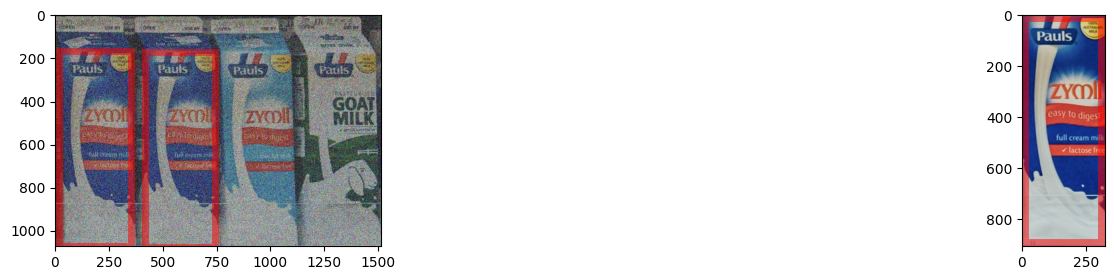

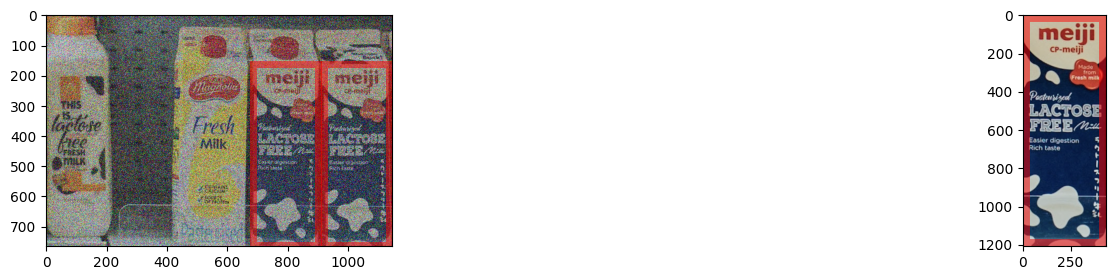

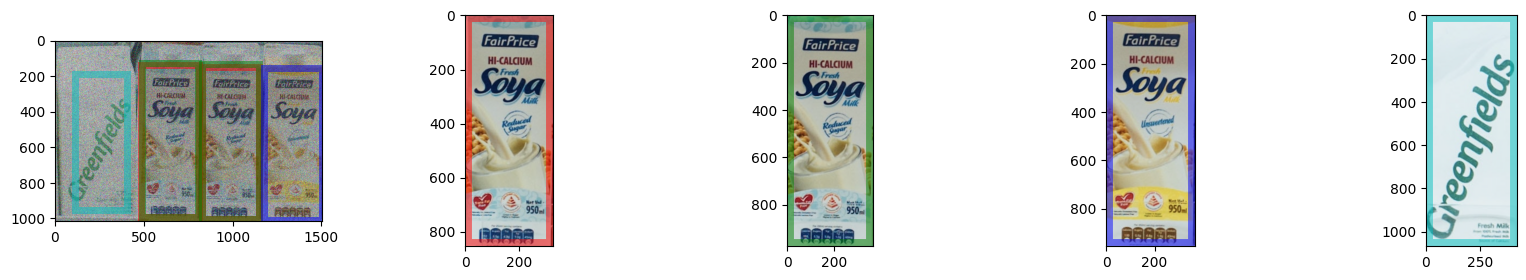

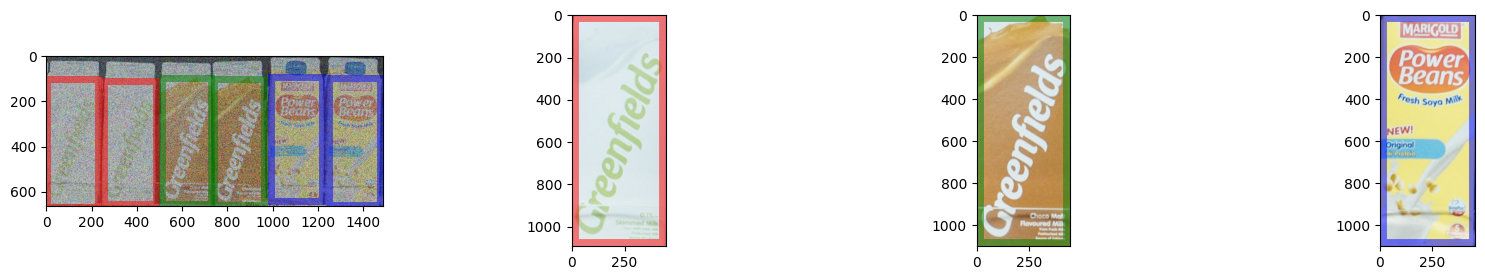

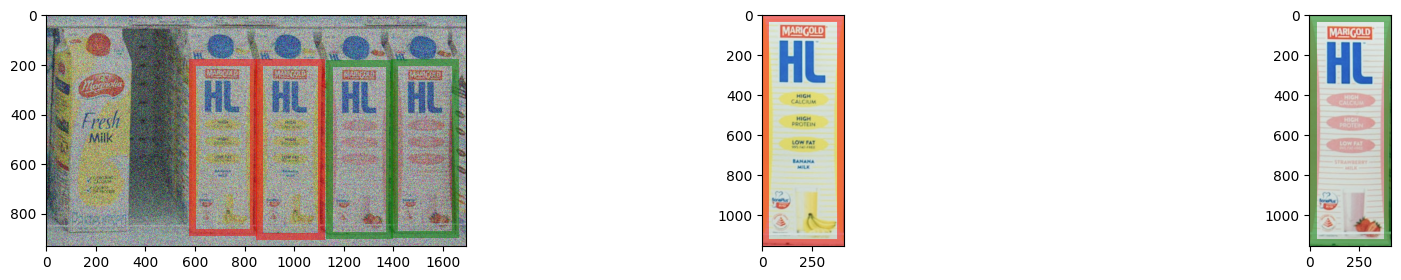

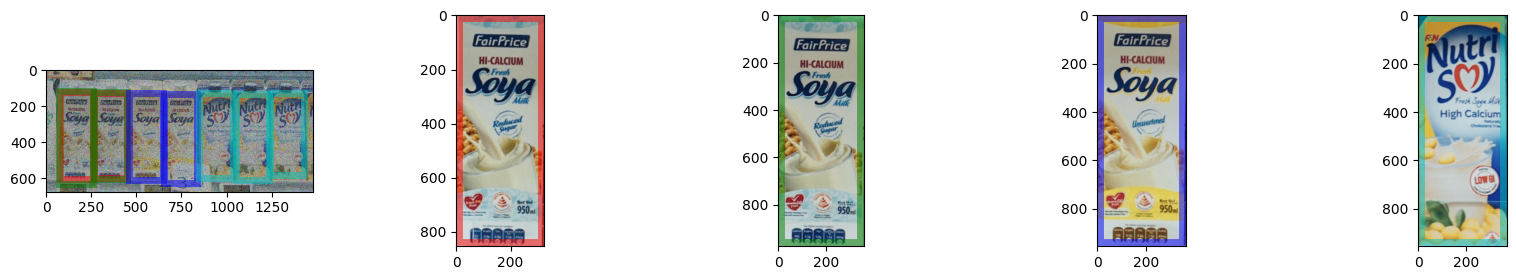

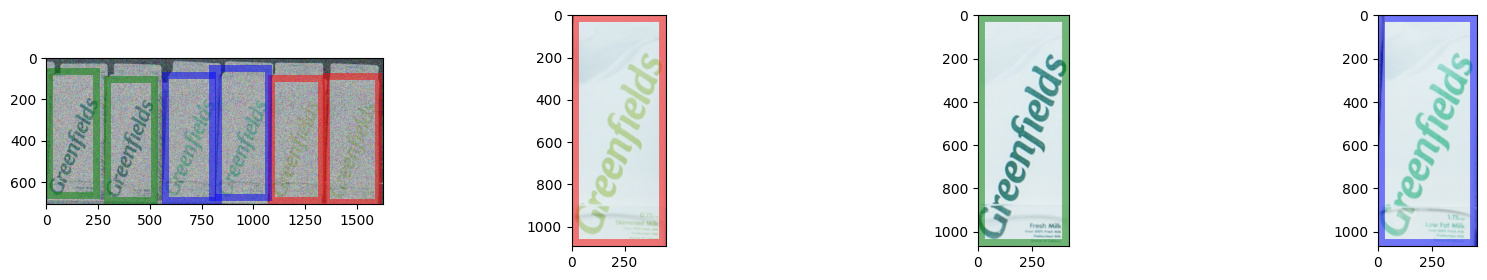

In [26]:
predictions_multi = { idx: {} for idx in MULTIPLE_INSTANCES_SCENE_IDXS }
plot_data_multi = { idx: {} for idx in MULTIPLE_INSTANCES_SCENE_IDXS }


for scene_idx, scene in zip(MULTIPLE_INSTANCES_SCENE_IDXS, multi_instance_scenes):
    scene_keypoints = filterKeypoints(scene)
    scene_color = filterColor(scene)

    for template_idx, template_features in zip(MULTIPLE_INSTANCES_TEMPLATE_IDXS, multi_templates_features):
        # if template_idx not in multi_instance_ground_truth[scene_idx]: continue
        instances_vertexes = multiInstanceDetection(scene_keypoints, scene_color, template_features)
        
        if len(instances_vertexes) == 0: 
            logger.info(f"Product {template_idx} - Scene {scene_idx} - No match found")
            continue
        
        printResults(scene_idx, template_idx, instances_vertexes)
        predictions_multi[scene_idx][template_idx] = len(instances_vertexes)
        plot_data_multi[scene_idx][template_idx] = (instances_vertexes, template_features.image)


if SHOW_PLOTS:
    for scene_idx, scene in zip(MULTIPLE_INSTANCES_SCENE_IDXS, multi_instance_scenes):
        num_detections = len(plot_data_multi[scene_idx])
        plt.figure(figsize=(20, 3))
        plt.subplot(1, 1+num_detections, 1)
        plt.imshow(scene)
        for i, template_idx in enumerate(plot_data_multi[scene_idx]):
            for matched_vertexes in plot_data_multi[scene_idx][template_idx][0]:
                top_left, width, height = formatResultBox(matched_vertexes)
                plt.gca().add_patch( patches.Rectangle(top_left, width, height, linewidth=5, fill=False, alpha=0.5, color=getRandomColor(i)) )
        for i, template_idx in enumerate(plot_data_multi[scene_idx]):
            image = plot_data_multi[scene_idx][template_idx][1]
            plt.subplot(1, 1+num_detections, 2+i)
            plt.imshow(image)
            plt.gca().add_patch( patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=10, fill=False, alpha=0.5, color=getRandomColor(i)) )
        plt.show()

evaluate(predictions_multi, multi_instance_ground_truth)